In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
# Load and preprocess the data
def load_air_quality_data():
    # Load the dataset from the provided local path
    file_path = r"D:\Github Repos\19CSE456-NNDL\RNN\AirQualityUCI.csv"  # Raw string to handle backslashes correctly
    df = pd.read_csv(file_path, sep=';', decimal=',')
    
    # Select relevant features
    df = df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)']]
    
    # Handle missing values: replace -200 (invalid readings) with NaN
    df.replace(-200, np.nan, inplace=True)
    
    # Drop rows with missing values
    df.dropna(inplace=True)
    
    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    
    return scaled_data, scaler

In [18]:
# Prepare sequences for time series prediction
def prepare_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 1:])  # Multivariate input features
        y.append(data[i + time_steps, 0])     # Next hour's 'CO(GT)'
    return np.array(X), np.array(y)

In [19]:
# Build the LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1)  # Output a single value for CO(GT)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [20]:
# Plot actual vs predicted values
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual CO(GT)')
    plt.plot(y_pred, label='Predicted CO(GT)')
    plt.title('Actual vs Predicted CO(GT)')
    plt.xlabel('Time')
    plt.ylabel('CO(GT)')
    plt.legend()
    plt.show()

In [21]:
# Plot training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

Epoch 1/20


c:\Users\gurup\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0719 - mae: 0.2022 - val_loss: 0.0246 - val_mae: 0.1286
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308 - mae: 0.1351 - val_loss: 0.0207 - val_mae: 0.1142
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0258 - mae: 0.1238 - val_loss: 0.0201 - val_mae: 0.1135
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0270 - mae: 0.1279 - val_loss: 0.0191 - val_mae: 0.1102
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0234 - mae: 0.1153 - val_loss: 0.0188 - val_mae: 0.1103
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0238 - mae: 0.1194 - val_loss: 0.0171 - val_mae: 0.1026
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - mae: 0.1170 - val_loss: 0.0162 - val_mae: 0.0995
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0201 - mae: 0.1103 - val_loss: 0.0152 - val_mae: 0.0943
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199 - mae: 0.1073 - 

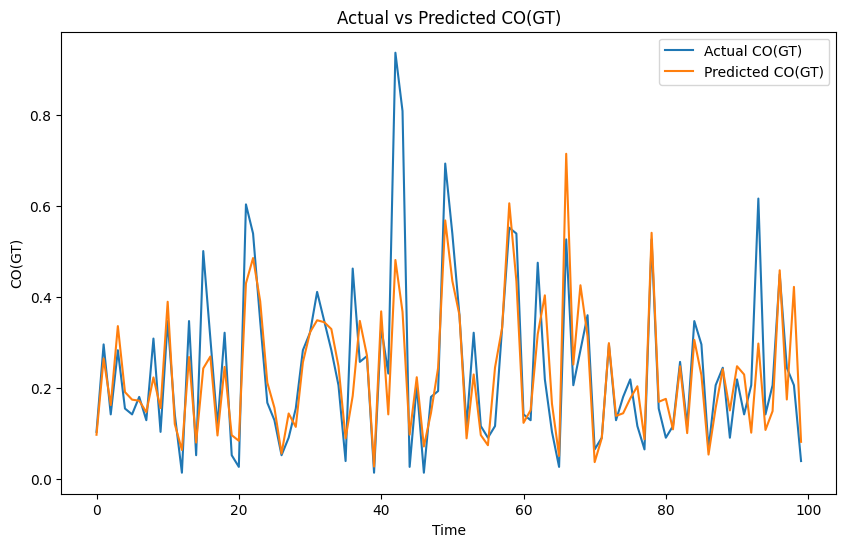

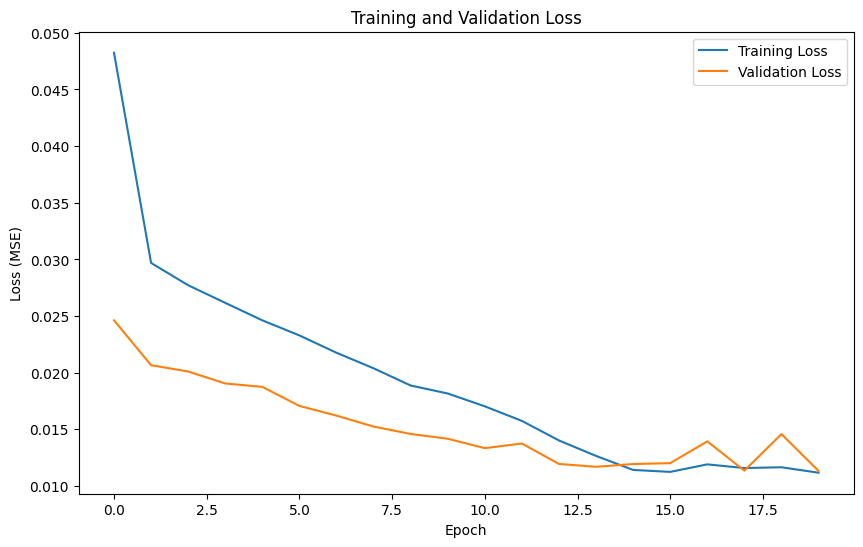

In [22]:
# Main function to run the workflow
def main():
    # Load and preprocess the data
    data, scaler = load_air_quality_data()
    
    # Prepare sequences (24 hours as input, next hour CO(GT) as output)
    X, y = prepare_sequences(data, time_steps=24)
    
    # Split data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Build and train the model
    model = build_model(X_train.shape[1:])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    # Plot actual vs predicted values
    plot_predictions(y_test[:100], y_pred[:100])  # Plot for the first 100 test samples
    
    # Plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()